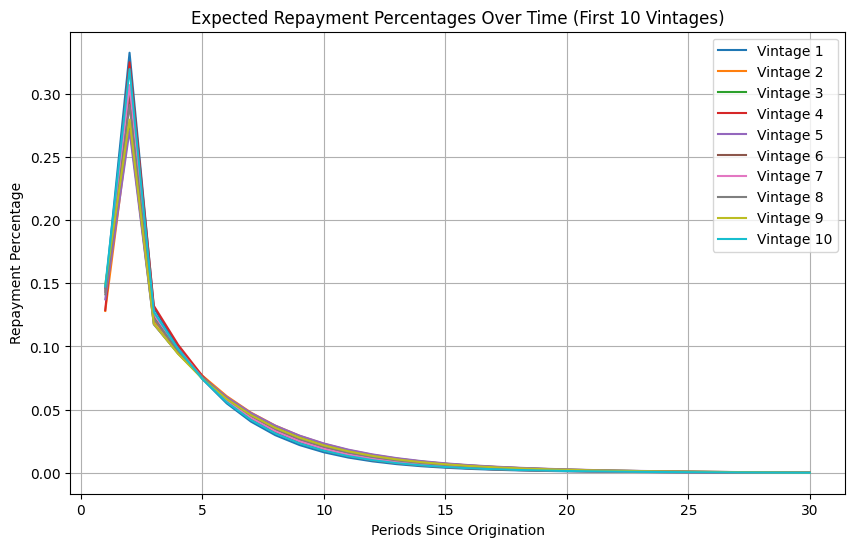

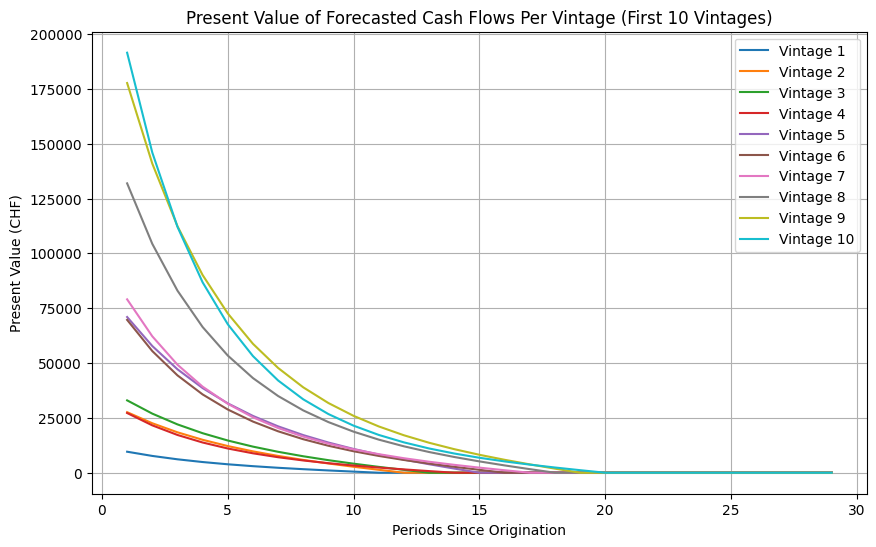

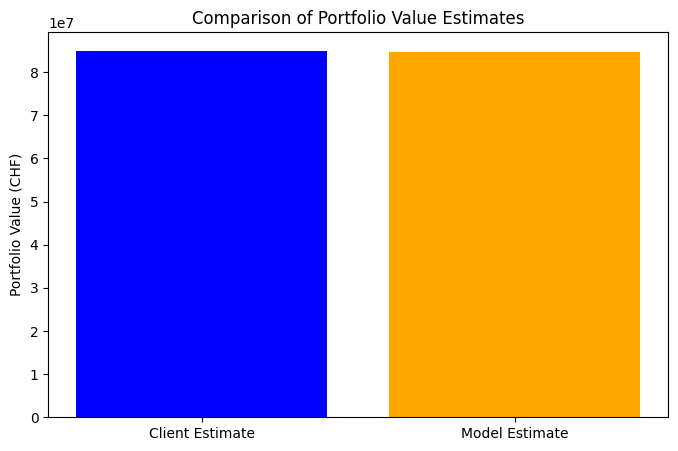

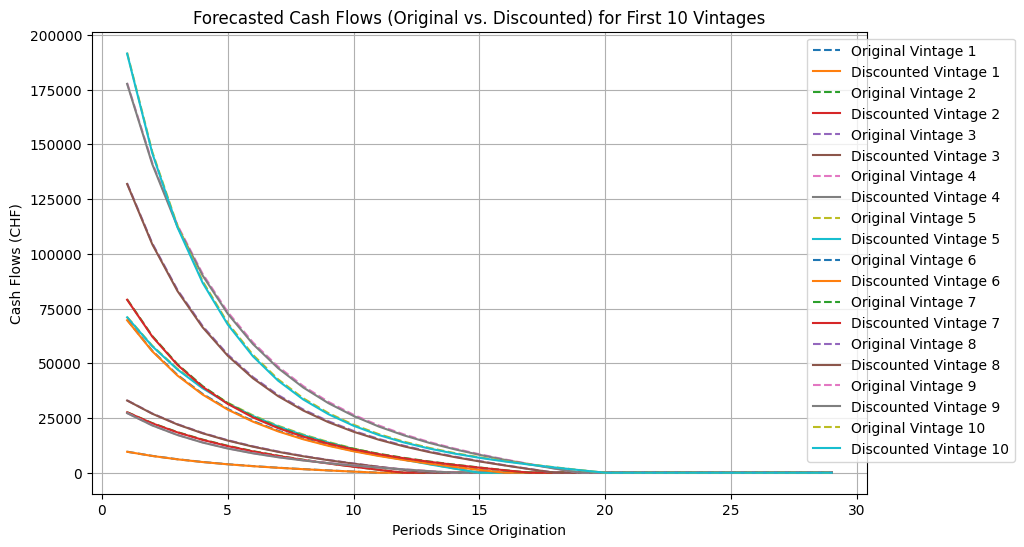

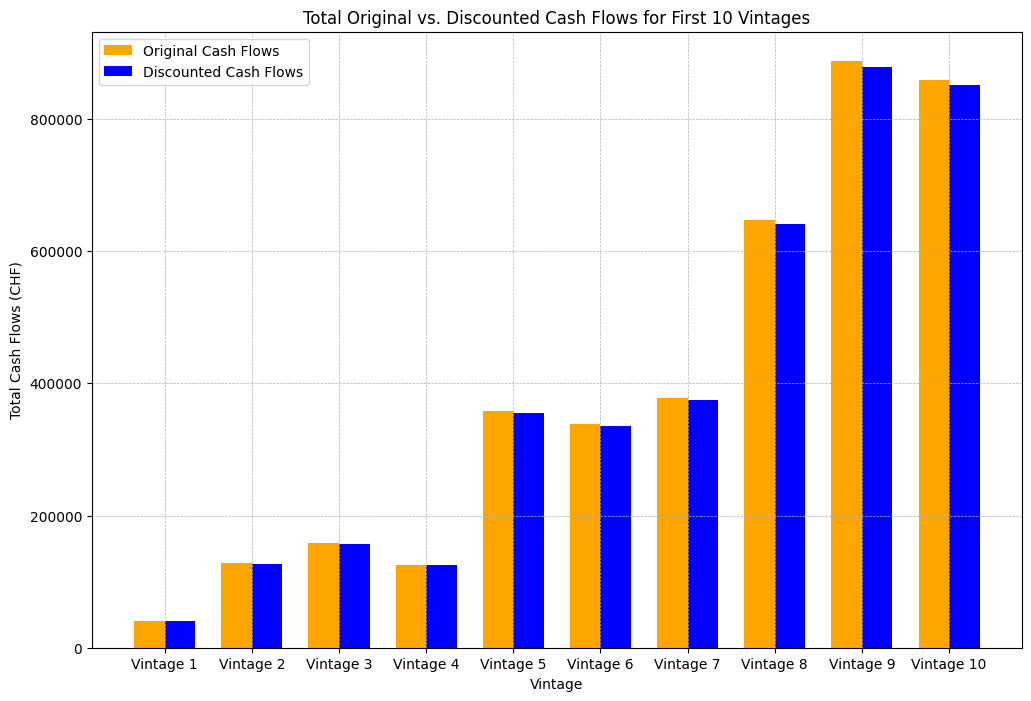

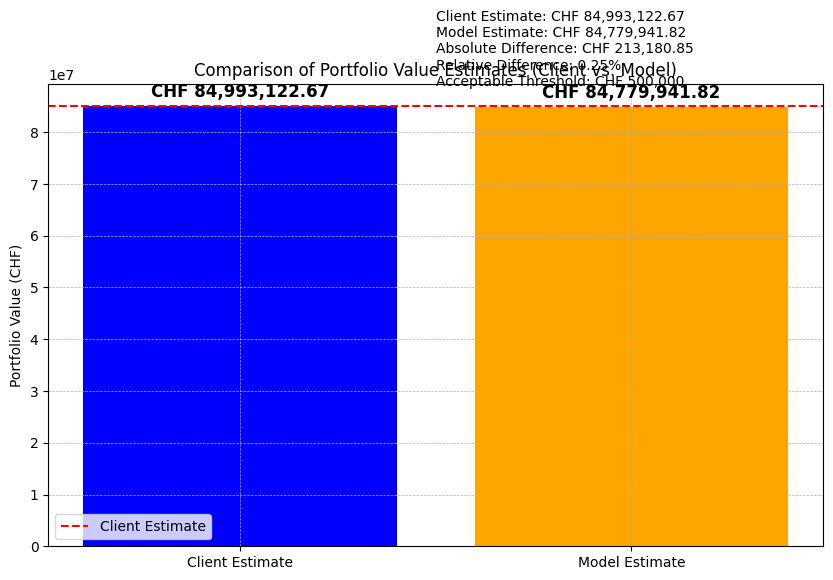

In [2]:
# =====================================
# 📘 **1. Import Libraries**
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# =====================================
# 📘 **2. Load Data**
# =====================================

# Load the data
data = pd.read_csv("Data.csv", sep=";")


# =====================================
# 📘 **3. Set Parameters**
# =====================================

n_forecast = 30  # Number of forecast periods
n_vintage = data.shape[0]  # Number of vintages
discount_rate = 0.025  # Discount rate (annual)


# =====================================
# 📘 **4. Extract Historical Data**
# =====================================

# Extract historical cash flows and amounts originated
historical_cf = data.iloc[:, 2:].to_numpy()  # Cash flows already observed
amount_originated = data.iloc[:, 1].to_numpy()  # Amounts originated per vintage


# =====================================
# 📘 **5. Calculate Repayment Percentages**
# =====================================

# Calculate periods remaining
periods_remaining = n_forecast - np.arange(n_vintage, 0, -1)  # Number of periods to be forecasted per vintage

# Calculate paid percentages
paid_percentages = historical_cf / amount_originated[:, np.newaxis]  # Historical payments as a percentage of the originated amount per vintage


# =====================================
# 📘 **6. Calculate First and Second Period Repayments**
# =====================================

# Calculate first and second period repayments
first_period = np.diag(paid_percentages)
second_period = np.concatenate(
    (np.diag(paid_percentages[:-1, 1:]),
     [paid_percentages[n_vintage - 1, n_vintage - 1] * 2])  # Assume second cash flow is twice the first cash flow for the last vintage
)


# =====================================
# 📘 **7. Forecast Repayment Percentages**
# =====================================

# Initialize the p matrix with zeros
p = np.zeros((n_vintage, n_forecast))
p[:, 0] = first_period
p[:, 1] = second_period

# Calculate expected repayment percentages
for i in range(n_vintage):
    for j in range(2, n_forecast):
        p[i, j] = max(0, p[i, 1] * np.log(1 + (1 - np.sum(p[i, :j]))) * (1 - (j) / n_forecast))


# =====================================
# 📘 **8. Forecast Cash Flows**
# =====================================

# Initialize forecasted expected repayment percentages
p_forecast = np.zeros((n_vintage, n_forecast - 1))

# Assign forecasted repayment percentages
for i in range(n_vintage):
    for j in range(periods_remaining[i]):
        p_forecast[i, j] = p[i, n_forecast - periods_remaining[i] + j]


# =====================================
# 📘 **9. Calculate Discounted Cash Flows**
# =====================================

# Calculate discount factors
discount_factors = 1 / (1 + discount_rate) ** (np.arange(1, n_forecast) / 12)  # Monthly discount factors

# Calculate the present value of forecasted cash flows
pv = (p_forecast * discount_factors) * amount_originated[:, np.newaxis]


# =====================================
# 📘 **10. Calculate Portfolio Value**
# =====================================

# Sum of all present values
portfolio_value = np.sum(pv)


# =====================================
# 📘 **11. Client Valuation Comparison**
# =====================================

client_estimate = 84993122.67  # Client's estimated value

# Calculate absolute and relative difference
absolute_difference = abs(portfolio_value - client_estimate)
relative_difference = absolute_difference / client_estimate

# Determine if the difference is within the acceptable threshold
acceptable_threshold = 500000  # Threshold for acceptable difference
within_threshold = absolute_difference < acceptable_threshold


# =====================================
# 📘 **12. Visualize Expected Repayment Percentages**
# =====================================

plt.figure(figsize=(10, 6))
for i in range(min(10, n_vintage)):  # Plot for first 10 vintages
    plt.plot(range(1, n_forecast + 1), p[i, :], label=f'Vintage {i+1}')
plt.title('Expected Repayment Percentages Over Time (First 10 Vintages)')
plt.xlabel('Periods Since Origination')
plt.ylabel('Repayment Percentage')
plt.legend()
plt.grid(True)
plt.show()


# =====================================
# 📘 **13. Visualize Present Value of Forecasted Cash Flows**
# =====================================

plt.figure(figsize=(10, 6))
for i in range(min(10, n_vintage)):  # Plot for first 10 vintages
    plt.plot(range(1, n_forecast), pv[i, :], label=f'Vintage {i+1}')
plt.title('Present Value of Forecasted Cash Flows Per Vintage (First 10 Vintages)')
plt.xlabel('Periods Since Origination')
plt.ylabel('Present Value (CHF)')
plt.legend()
plt.grid(True)
plt.show()


# =====================================
# 📘 **14. Visualize Portfolio Valuation Comparison**
# =====================================

labels = ['Client Estimate', 'Model Estimate']
values = [client_estimate, portfolio_value]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.title('Comparison of Portfolio Value Estimates')
plt.ylabel('Portfolio Value (CHF)')
plt.show()


# =====================================
# 📘 **15. Visualize Forecasted Cash Flows (Original vs. Discounted)**
# =====================================

forecasted_cash_flows_original = p_forecast * amount_originated[:, np.newaxis]
forecasted_cash_flows_discounted = forecasted_cash_flows_original * discount_factors

plt.figure(figsize=(10, 6))
for i in range(min(10, n_vintage)):  # Plot for first 10 vintages
    plt.plot(range(1, n_forecast), forecasted_cash_flows_original[i, :], label=f'Original Vintage {i+1}', linestyle='dashed')
    plt.plot(range(1, n_forecast), forecasted_cash_flows_discounted[i, :], label=f'Discounted Vintage {i+1}')
plt.title('Forecasted Cash Flows (Original vs. Discounted) for First 10 Vintages')
plt.xlabel('Periods Since Origination')
plt.ylabel('Cash Flows (CHF)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()


# =====================================
# 📘 **16. Visualize Total Cash Flows (Original vs. Discounted)**
# =====================================

total_original_cash_flows = np.sum(forecasted_cash_flows_original, axis=1)
total_discounted_cash_flows = np.sum(forecasted_cash_flows_discounted, axis=1)

x = np.arange(min(10, n_vintage))
width = 0.35  # Width of the bars

plt.figure(figsize=(12, 8))
plt.bar(x - width / 2, total_original_cash_flows[:10], width, label='Original Cash Flows', color='orange')
plt.bar(x + width / 2, total_discounted_cash_flows[:10], width, label='Discounted Cash Flows', color='blue')
plt.xlabel('Vintage')
plt.ylabel('Total Cash Flows (CHF)')
plt.title('Total Original vs. Discounted Cash Flows for First 10 Vintages')
plt.xticks(x, labels=[f'Vintage {i+1}' for i in range(10)])
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


# =====================================
# 📘 **17. Final Portfolio Comparison (Client vs. Model)**
# =====================================

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'orange'])

# Add value annotations
for i, val in enumerate(values):
    plt.text(i, val + 1000000, f"CHF {val:,.2f}", ha='center', va='bottom', fontweight='bold', fontsize=12)

# Title and labels
plt.title('Comparison of Portfolio Value Estimates (Client vs. Model)')
plt.ylabel('Portfolio Value (CHF)')
plt.axhline(y=client_estimate, color='red', linestyle='--', label='Client Estimate')
comparison_text = (
    f'Client Estimate: CHF {client_estimate:,.2f}\n'
    f'Model Estimate: CHF {portfolio_value:,.2f}\n'
    f'Absolute Difference: CHF {absolute_difference:,.2f}\n'
    f'Relative Difference: {relative_difference * 100:.2f}%\n'
    f'Acceptable Threshold: CHF 500,000'
)
plt.text(0.5, client_estimate + 4000000, comparison_text)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()
